In [1]:
#tensorflow 버전 확인
import tensorflow as tf
print(tf.__version__)

2.6.0


In [2]:
# GPU 사용하는 경우, device list에 GPU 있는지 확인
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 287617892235488180
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7799308288
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11304788794535313962
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [3]:
#필요한 모듈 불러오기
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification,utils

# attention mask 시각화를 위한 모듈
from bertviz import model_view
utils.logging.set_verbosity_error()

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

from tabulate import tabulate
from tqdm import trange
import random
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


print("GPU available:",torch.cuda.is_available())

GPU available: True


In [4]:
# data 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
# Price 속성 리뷰
url='./data/price_total.csv'
df = pd.read_csv(url,sep=',', header=0, encoding_errors='ignore')
df.head(5)

,id,text,category,polarity
0,1476493:3,"When you add it all together, it just doesn't ...",price,0
1,2156,The bagels are also reasonably priced for NYC.,price,1
2,2424,"It's true, this place is not cheap.",price,0
3,Z#3:2,"I paid just about $60 for a good meal, though :)",price,1
4,2645,BUt their best dish is thh Thai spiced curry n...,price,1


In [10]:
df.dtypes

id          object
text        object
category    object
polarity     int64
dtype: object

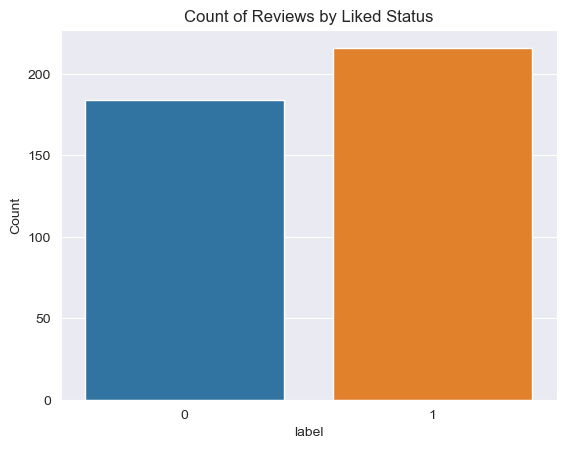

In [5]:
# review data의 label 분포
sns.set_style('darkgrid')

# Create a count plot of the "Liked" column
sns.countplot(x='polarity', data=df)

# Set the title of the plot
plt.title('Count of Reviews by Liked Status')

# Set the label for the x-axis
plt.xlabel('label')

# Set the label for the y-axis
plt.ylabel('Count')

# Show the plot
plt.show()

In [12]:
count_neg = len(df[df['polarity'] == 0])
count_pos=len(df[df['polarity'] == 1])
print("positive: {}, negative: {}".format(count_pos,count_neg))

positive: 216, negative: 184


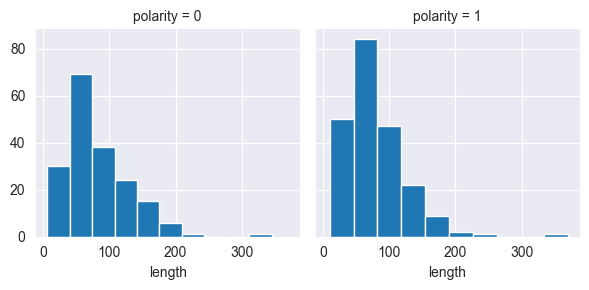

In [13]:
# review data의 길이 분포 및 통계
df_new=df
df_new['length'] = df['text'].apply(len)

g = sns.FacetGrid(df, col='polarity')

g.map(plt.hist, 'length');

In [14]:
df_new.length.describe()

count    400.000000
mean      79.477500
std       47.393616
min        6.000000
25%       47.000000
50%       70.000000
75%      102.000000
max      370.000000
Name: length, dtype: float64

In [6]:
text = df.text.values
labels = df.polarity.values

In [7]:
# 전처리를 위한 tokenizer 불러오기
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
    )

In [8]:
#전처리
MAX_LENGTH=150
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer,max_len_input=MAX_LENGTH):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = max_len_input,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                        truncation=True
                   )


for sample in text:
  encoding_dict = preprocessing(sample, tokenizer)

  # token_id 리스트 추출
  token_id.append(encoding_dict['input_ids']) 
  # attention_mask 리스트 추출
  attention_masks.append(encoding_dict['attention_mask'])


# 리스트를 텐서로
token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

In [9]:
#데이터 train set, validation set 분리
VAL_RATIO= 0.2
batch_size = 8 

# Indices of the train and validation splits stratified by labels
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size = VAL_RATIO,
    shuffle = True,
    stratify = labels)

# Train and validation sets
train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          labels[train_idx])

val_set = TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        labels[val_idx])

# Prepare DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )


print("train: {}".format(len(train_idx)))
print("validation: {}".format(len(val_idx)))


train: 320
validation: 80


In [10]:
#accuracy 측정을 위한 함수 정의
def b_tp(preds, labels):
  '''Returns True Positives (TP): count of correct predictions of actual class 1'''
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
  '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
  '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
  '''
  Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - specificity = TN / (TN + FP)
  '''
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  fp = b_fp(preds, labels)
  fn = b_fn(preds, labels)
  b_accuracy = (tp + tn) / len(labels)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
  return b_accuracy, b_precision, b_recall, b_specificity

In [11]:
# BERT 모델 불러오기
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 2,
    output_attentions = True,
    output_hidden_states = False,
)


optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 5e-5, # learning rate 설정
                              eps = 1e-08
                              )


# GPU 확인 및 할당
if torch.cuda.is_available():
    device=torch.device('cuda')
    print("GPU available.")
else:
    device=torch.device("cpu")
    print("No GPU available, using CPU instead.")


#model.cuda()
model.to(device)

GPU available.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [12]:
# 학습 횟수 설정
epochs = 10

idx=0
epo_list=[]
train_loss_list=[]
val_accuracy_list=[]

#학습 시작
for _ in trange(epochs, desc = 'Epoch'):
    idx+=1
    epo_list.append(idx)

    # ========== Training ==========
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========
    model.eval()

    # Tracking variables 
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    val_accuracy_temp=sum(val_accuracy)/len(val_accuracy)
    train_loss_list.append(round(tr_loss / nb_tr_steps,4))
    val_accuracy_list.append(round(val_accuracy_temp,4))
    #print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    #print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    #print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')


Epoch:  10%|███████▌                                                                    | 1/10 [00:03<00:35,  3.97s/it]


	 - Train loss: 0.6091
	 - Validation Accuracy: 0.8125


Epoch:  20%|███████████████▏                                                            | 2/10 [00:06<00:26,  3.36s/it]


	 - Train loss: 0.2738
	 - Validation Accuracy: 0.7750


Epoch:  30%|██████████████████████▊                                                     | 3/10 [00:09<00:22,  3.17s/it]


	 - Train loss: 0.1195
	 - Validation Accuracy: 0.8500


Epoch:  40%|██████████████████████████████▍                                             | 4/10 [00:12<00:18,  3.08s/it]


	 - Train loss: 0.0784
	 - Validation Accuracy: 0.8250


Epoch:  50%|██████████████████████████████████████                                      | 5/10 [00:15<00:15,  3.03s/it]


	 - Train loss: 0.0219
	 - Validation Accuracy: 0.9000


Epoch:  60%|█████████████████████████████████████████████▌                              | 6/10 [00:18<00:12,  3.00s/it]


	 - Train loss: 0.0115
	 - Validation Accuracy: 0.8875


Epoch:  70%|█████████████████████████████████████████████████████▏                      | 7/10 [00:21<00:08,  2.98s/it]


	 - Train loss: 0.0267
	 - Validation Accuracy: 0.8875


Epoch:  80%|████████████████████████████████████████████████████████████▊               | 8/10 [00:24<00:05,  2.98s/it]


	 - Train loss: 0.0705
	 - Validation Accuracy: 0.8500


Epoch:  90%|████████████████████████████████████████████████████████████████████▍       | 9/10 [00:27<00:02,  2.97s/it]


	 - Train loss: 0.0200
	 - Validation Accuracy: 0.8750


Epoch: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:30<00:00,  3.05s/it]


	 - Train loss: 0.0108
	 - Validation Accuracy: 0.8625


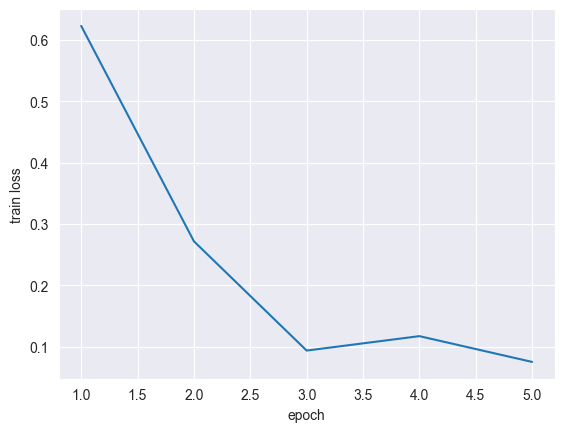

In [23]:
# train loss 그래프
plt.plot(epo_list, train_loss_list)
plt.xlabel('epoch')
plt.ylabel('train loss')
plt.show()

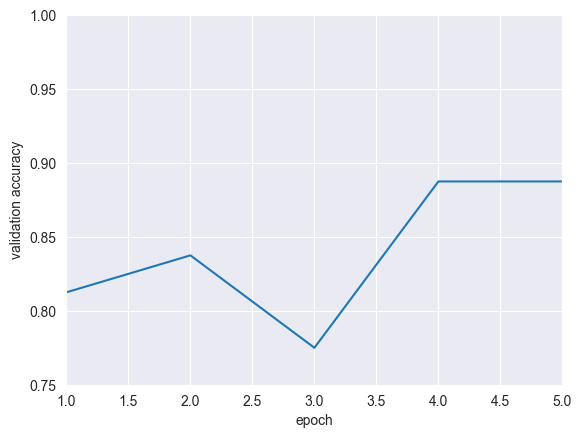

In [24]:
#validation accuracy 그래프
plt.plot(epo_list, val_accuracy_list)
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.axis([1,epochs , 0.75, 1])
plt.show()

In [13]:
#새로운 리뷰 분류해보기

def test_sentence(sentence):
    # 토큰 ID와 attention mask를 위한 리스트
    test_ids = []
    test_attention_mask = []

    # 전처리
    encoding = preprocessing(sentence, tokenizer)
    test_ids.append(encoding['input_ids'])
    test_attention_mask.append(encoding['attention_mask'])
    test_ids = torch.cat(test_ids, dim = 0)
    test_attention_mask = torch.cat(test_attention_mask, dim = 0)
    
    # Forward pass, calculate logit predictions
    with torch.no_grad():
        output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

    prediction = 'Positive' if np.argmax(output.logits.cpu().numpy()).flatten().item() == 1 else 'Negative'
    return prediction
    
    
new_sentence ='The food was bad, but it was cheap'


print('입력 문장:', new_sentence)
print('분류:', test_sentence(new_sentence))

입력 문장: The food was bad, but it was cheap
분류: Positive


In [14]:
#test data 세팅

# data 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
test_url='./data/price_test.csv'
df = pd.read_csv(test_url,sep=',', header=0, encoding_errors='ignore')
df.head(5)

,id,text,category,polarity
0,en_SnoozeanAMEatery_480171723:7,The pancakes were certainly inventive but $8.5...,price,0
1,32899414#512291#3,Cuisine is billed as asian fusion - doesn't me...,price,0
2,13383936#420974#1,I found the food to be just as good as its own...,price,1
3,11538980#1053497#4,But make sure you have enough room on your cre...,price,0
4,32889544#0#0,A mix of students and area residents crowd int...,price,1


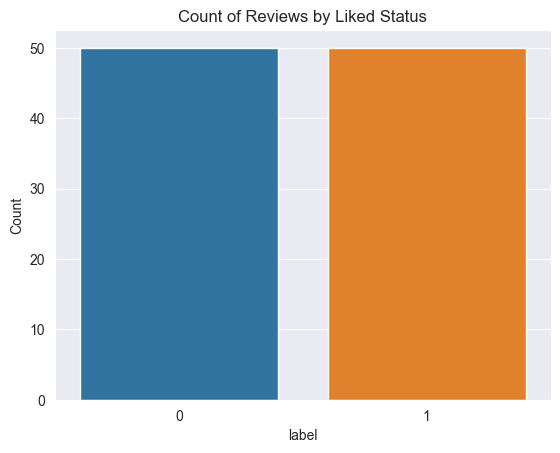

In [27]:
# review data의 label 분포
sns.set_style('darkgrid')

# Create a count plot of the "Liked" column
sns.countplot(x='polarity', data=df)

# Set the title of the plot
plt.title('Count of Reviews by Liked Status')

# Set the label for the x-axis
plt.xlabel('label')

# Set the label for the y-axis
plt.ylabel('Count')

# Show the plot
plt.show()

In [15]:
# 모든 test data에 대한 분류 및 accuracy 측정
count=0

test_text = df.text.values
test_labels = df.polarity.values

wrongResult=[]

for i in range(len(test_labels)):
    t = df.iloc[i].text
    color_s='\033[31m' 
    color_e='\033[0m'
    
    prediction=test_sentence(t)
    if(prediction=="Negative"):
        result=0
    else:
        result=1
        
    if(result==df.iloc[i].polarity):
        count+=1     
        color_s=''
        color_e=''
    else:
        wrongResult.append(t)
    print(color_s+"=============================== Input {} ===============================".format(i+1))
    print(t)
    print("model result:",prediction,"\nanswer:", df.iloc[i].polarity,color_e)
    print("")


print("test accuracy: {:.4f}".format(count/len(test_labels)))
    

=============================== Input 1 ===============================
The pancakes were certainly inventive but $8.50 for 3 - 6" pancakes (one of them was more like 5") in the pancake flight (sample of 3 different pancakes) is well over-priced.
model result: Negative 
answer: 0 

=============================== Input 2 ===============================
Cuisine is billed as asian fusion - doesn't meet the bill.
model result: Negative 
answer: 0 

=============================== Input 3 ===============================
I found the food to be just as good as its owner, Da Silvano, just much less expensive.
model result: Positive 
answer: 1 

=============================== Input 4 ===============================
But make sure you have enough room on your credit card as the bill will leave a big dent in your wallet.
model result: Negative 
answer: 0 

=============================== Input 5 ===============================
A mix of students and area residents crowd into this narrow, barely t

=============================== Input 55 ===============================
The happy hour is so cheap, but that does not reflect the service or the atmosphere.
model result: Negative 
answer: 1 

=============================== Input 56 ===============================
Great value sushi with high quality & nice setting.
model result: Positive 
answer: 1 

=============================== Input 57 ===============================
His food is excellent (and not expensive by NYC standards- no entrees over $30, most appetizers $12 to 14).
model result: Positive 
answer: 1 

=============================== Input 58 ===============================
I liked the atmosphere very much but the food was not worth the price.
model result: Negative 
answer: 0 

=============================== Input 59 ===============================
Good Sushi, High Price
model result: Positive 
answer: 0 

=============================== Input 60 ===============================
Although I moved uptown I try to stop in as

In [29]:
print(wrongResult)

['Anywhere else, the prices would be 3x as high!', 'The price was right too.', 'Simple healthy unglamorous food cheap.', 'I can understand the prices if it served better food, like some Chinese restaurants in midtown/uptown area.', "I'm astonished that this restaurant is categorized as $$$ rather than $$$$.", 'Chinatown definitely has better quality with cheaper prices.', 'i have eaten here on a different occasion - the food is mediocre for the prices.', 'The happy hour is so cheap, but that does not reflect the service or the atmosphere.', 'Although I moved uptown I try to stop in as often as possible for the GREAT cheap food and to pay the friendly staff a visit.', 'In the end our check came to $27 for 4 small pancakes, a breakfast burrito, an orange juice and an iced tea (I had water).', "You're going to drop some coin, but completely worth it, especially if you are looking to impress someone.", 'Excellent food, nice ambience, fairly expensive', 'I recommend it for a night when you 

In [16]:
#문장의 BERT attention을 추출해보자

# 개별 문장의 attention 추출하는 함수
def get_attention(encoding):
    # 토큰 ID와 attention mask를 위한 리스트
    test_ids = []
    test_attention_mask = []
    test_ids.append(encoding['input_ids'])
    test_attention_mask.append(encoding['attention_mask'])
    test_ids = torch.cat(test_ids, dim = 0)
    test_attention_mask = torch.cat(test_attention_mask, dim = 0)
    
    
    # Forward pass, calculate logit predictions
    with torch.no_grad():
        model_output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))
        
    prediction = 'Positive' if np.argmax(model_output.logits.cpu().numpy()).flatten().item() == 1 else 'Negative'
    attention=model_output[-1]
    last_attention=attention[-1]
    tokens=tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])
    
    return attention,last_attention,tokens,prediction

In [17]:
def get_val_len(ids):
    count=0
    for elem in ids:
        if(elem!=0):
            count+=1
    return count

In [18]:
# bertviz를 이용한 attention 시각화
from bertviz import head_view

sent="Terrible service, but cheap and reasonable price."

# 전처리
encoding = preprocessing(sent, tokenizer,10)


retAtt,retLastAtt,retTok,prediction=get_attention(encoding)

print('입력 문장:', sent)
print('분류:', prediction)
print()

head_view(retAtt,retTok)


입력 문장: Terrible service, but cheap and reasonable price.
분류: Positive



<IPython.core.display.Javascript object>

In [19]:
def sort_by_att(attention,tokens):
    '''
        last layer의 attention tensor를 입력 받아 각 token의 attention 값을 head에 대한 평균을 낸 뒤, attention이 높은 token 순으로 idx를 반환하는 함수
    '''
    
    attention=attention[0] # shape: 12,len,len
    
    size=len(tokens)
    
    total_atts_sum=[] # 각 head에 대한 각 토큰의 attention값의 합
    for head in range(0,12):
        att_of_head=attention[head] # 한 head의 attention
        atts_sum_of_head=[0.0]*size # 해당 head 하나의 attention의 합
        for row in att_of_head:
            col=0
            for elem in row:
                value=elem.item()
                atts_sum_of_head[col]+=value # head 하나에 대한 토큰이 가지는 attention 값
                col+=1
        total_atts_sum.append(atts_sum_of_head)
    
    total_sum_value=[0.0]*size
    for elem in total_atts_sum:
        for i in range(0,size):
            total_sum_value[i]+=elem[i]
            

    total_mean=[]
    for elem in total_sum_value:
        total_mean.append(elem/12)
    
    


    idxs=sorted(range(len(total_mean)), key=lambda k: total_mean[k], reverse=True)
    return(idxs)
    

In [20]:
# attention 순서대로 텍스트 배경색 주기
color_code=[
    "\033[48;5;243m",
    "\033[48;5;245m",
    "\033[48;5;247m",
    "\033[48;5;249m",
    "\033[48;5;251m",
    "\033[48;5;253m",
    "\033[48;5;255m"
]
def emp_by_att(attIdxs,tokens):   
    valTokens=[]
    for tok in tokens:
        if(tok!='[CLS]' and tok!='[PAD]' and tok!='[SEP]'):
            valTokens.append(tok)
        
    valIdxs=[]
    for idx in attIdxs:
        if len(valIdxs)==7:
            break;
        
        if(idx>0 and idx<=len(valTokens)):
            if(valTokens[idx-1]!=',' and valTokens[idx-1]!='.'):
                valIdxs.append(idx-1)
    
    resultSent=""
    for i in range(len(valTokens)):
        if(i in valIdxs):
            outTok=color_code[valIdxs.index(i)]+valTokens[i]+"\033[0m"
        else:
            outTok=valTokens[i]
        resultSent+=outTok
        resultSent+=' '
    
    print("========================= emphasize by attention result==========================")
    print(resultSent)

In [21]:
def get_highest_att_tok(idxs,retTok,num):
    count=0
    print("highest attention: ",end="")
    for i in idxs:
        if(i<len(retTok)):
            if(retTok[i]!='[CLS]' and retTok[i]!='[SEP]' and retTok[i]!='.' and retTok[i]!=','):
                if(count<num):
                    print(retTok[i],end=" ")
                    count+=1
                

In [22]:
# 개별 문장을 attention이 높은 token 순으로 강조해 보여주기
idxs=sort_by_att(retLastAtt,retTok)

emp_by_att(idxs,retTok)

get_highest_att_tok(idxs,retTok,3)

========================= emphasize by attention result==========================
terrible service , but cheap and reasonable price 
highest attention: terrible reasonable but 

In [23]:
#잘못 분류된 문장의 attention
for sent in wrongResult:
    encoding = preprocessing(sent, tokenizer,50)
    MAX_LEN_IN=get_val_len(encoding['input_ids'][0])


    retAtt,retLastAtt,retTok,prediction=get_attention(encoding)

    print('입력 문장:', sent)
    print('분류:', prediction)
    print('MAX_LEN: ',MAX_LEN_IN)
    
    idxs=sort_by_att(retLastAtt,retTok)

    emp_by_att(idxs,retTok)
    
    get_highest_att_tok(idxs,retTok,4)
    print()
    print()
    print()
    print()

입력 문장: A mix of students and area residents crowd into this narrow, barely there space for its quick, tasty treats at dirt-cheap prices.
분류: Negative
MAX_LEN:  30
========================= emphasize by attention result==========================
a mix of students and area residents crowd into this narrow , barely there space for its quick , ta ##sty treats at dirt - cheap prices . 
highest attention: dirt barely crowd mix 



입력 문장: Anywhere else, the prices would be 3x as high!
분류: Negative
MAX_LEN:  14
========================= emphasize by attention result==========================
anywhere else , the prices would be 3 ##x as high ! 
highest attention: ! high would be 



입력 문장: It also has lots of other Korean dishes that are affordable and just as yummy.
분류: Negative
MAX_LEN:  19
========================= emphasize by attention result==========================
it also has lots of other korean dishes that are affordable and just as yu ##mmy . 
highest attention: yu affordable just a

In [24]:
#NAVER test data 세팅

# data/naver_data 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
test_url='./data/naver_data/naver_price_test.csv'
df = pd.read_csv(test_url,sep=',', header=0,encoding="CP949")
df.head(5)

,id,category,text,polarity,trans_text
0,1605,price,가격대는 좀 있네요. 이건물 식당들.\n모임했는데 분위기 괜찮았어요.,0,There's a bit of a price range. The restauran...
1,1192,price,맛은 물론이고 오마카세를 가성비 좋은 가격에 즐기기 좋았습니다 평택에서 스시는 여기...,1,It was good to enjoy omakase at a cost-effecti...
2,175,price,가격도 저렴 하고 맛있어요,1,It's cheap and delicious
3,1666,price,가격이 좀 비싸긴 하지만... 맛있습니다! \n지나갈 때마다 그냥지나치지 못하네요~~,0,"It's a little expensive, but... It's delicious..."
4,1188,price,친구들과 점심 뭐먹을까 찾다가 당일로 예약하고갔습니다~ 하나하나 꼼꼼한 설명과 가격...,1,I was looking for what to eat for lunch with m...


In [26]:
# naver data에 대한 분류 및 accuracy 측정
count=0

test_text = df.trans_text.values
test_labels = df.polarity.values

NaverWrongResult=[]
NaverRightResult=[]

for i in range(len(test_labels)):
    t = df.iloc[i].trans_text
    color_s='\033[31m' 
    color_e='\033[0m'
    
    prediction=test_sentence(t)
    if(prediction=="Negative"):
        result=0
    else:
        result=1
        
    if(result==df.iloc[i].polarity):
        count+=1     
        color_s=''
        color_e=''
        NaverRightResult.append(t)
    else:
        NaverWrongResult.append(t)
    print(color_s+"=============================== Input {} ===============================".format(i+1))
    print(t)
    print("model result:",prediction,"\nanswer:", df.iloc[i].polarity,color_e)
    print("")


print("test accuracy: {:.4f}".format(count/len(test_labels)))

=============================== Input 1 ===============================
There's a bit of a price range.  The restaurants in this building.. We had a meeting and the atmosphere was good.
model result: Positive 
answer: 0 

=============================== Input 2 ===============================
It was good to enjoy omakase at a cost-effective price as well as the taste This is the best sushi restaurant in Pyeongtaek><
model result: Positive 
answer: 1 

=============================== Input 3 ===============================
It's cheap and delicious
model result: Positive 
answer: 1 

=============================== Input 4 ===============================
It's a little expensive, but... It's delicious. Every time I pass by, I can't just pass by~~
model result: Negative 
answer: 0 

=============================== Input 5 ===============================
I was looking for what to eat for lunch with my friends, and I made a reservation for the day. The atmosphere was good and delicious with 

=============================== Input 43 ===============================
Considering the brunch, the price was good and the taste was good
model result: Positive 
answer: 1 

=============================== Input 44 ===============================
It's my first time going to a restaurant, but the food tastes good and the price range is good, so I think it's a good cost-effective restaurant!! Haha
model result: Positive 
answer: 1 

=============================== Input 45 ===============================
The price is rather high compared to the taste. It's not a special taste
model result: Negative 
answer: 0 

=============================== Input 46 ===============================
It feels a little expensive, but I sometimes go there because it's delicious
model result: Negative 
answer: 0 

=============================== Input 47 ===============================
It's such a famous place that there are many people. It's expensive, but quality is good
model result: Negative 
answer: 0 

In [27]:
#잘못 분류된 문장의 attention
for sent in NaverWrongResult:
    encoding = preprocessing(sent, tokenizer,50)
    MAX_LEN_IN=get_val_len(encoding['input_ids'][0])


    retAtt,retLastAtt,retTok,prediction=get_attention(encoding)

    print('입력 문장:', sent)
    print('분류:', prediction)
    print('MAX_LEN: ',MAX_LEN_IN)
    
    idxs=sort_by_att(retLastAtt,retTok)

    emp_by_att(idxs,retTok)
    
    get_highest_att_tok(idxs,retTok,4)
    print()
    print()
    print()
    print()

입력 문장: There's a bit of a price range.  The restaurants in this building.. We had a meeting and the atmosphere was good.
분류: Positive
MAX_LEN:  29
========================= emphasize by attention result==========================
there ' s a bit of a price range . the restaurants in this building . . we had a meeting and the atmosphere was good . 
highest attention: good atmosphere and was 



입력 문장: It's not a lot compared to the price, but it's convenient because you can make a reservation for lunch and it's set up right away.. However, the space between the seats is narrow, but it's a single-person crater, so the inside is a little hot because of the steam everywhere.
분류: Positive
MAX_LEN:  50
========================= emphasize by attention result==========================
it ' s not a lot compared to the price , but it ' s convenient because you can make a reservation for lunch and it ' s set up right away . . however , the space between the seats is narrow , but it ' s 
highest at

In [28]:
#잘 분류된 문장의 attention
for sent in NaverRightResult:
    encoding = preprocessing(sent, tokenizer,50)
    MAX_LEN_IN=get_val_len(encoding['input_ids'][0])


    retAtt,retLastAtt,retTok,prediction=get_attention(encoding)

    print('입력 문장:', sent)
    print('분류:', prediction)
    print('MAX_LEN: ',MAX_LEN_IN)
    
    idxs=sort_by_att(retLastAtt,retTok)

    emp_by_att(idxs,retTok)
    
    get_highest_att_tok(idxs,retTok,4)
    print()
    print()
    print()
    print()

입력 문장: It was good to enjoy omakase at a cost-effective price as well as the taste This is the best sushi restaurant in Pyeongtaek><
분류: Positive
MAX_LEN:  36
========================= emphasize by attention result==========================
it was good to enjoy om ##aka ##se at a cost - effective price as well as the taste this is the best su ##shi restaurant in p ##ye ##ong ##ta ##ek > < 
highest attention: at a price cost 



입력 문장: It's cheap and delicious
분류: Positive
MAX_LEN:  8
========================= emphasize by attention result==========================
it ' s cheap and delicious 
highest attention: cheap delicious s and 



입력 문장: It's a little expensive, but... It's delicious. Every time I pass by, I can't just pass by~~
분류: Negative
MAX_LEN:  33
========================= emphasize by attention result==========================
it ' s a little expensive , but . . . it ' s delicious . every time i pass by , i can ' t just pass by ~ ~ 
highest attention: expensive but ~ delic

========================= emphasize by attention result==========================
it was delicious , but the amount is small compared to the price . 
highest attention: but small is amount 



입력 문장: An old waffle restaurant! I think it was so delicious even though it's been a while since I visited. It's expensive, but it reminds me of the taste
분류: Negative
MAX_LEN:  38
========================= emphasize by attention result==========================
an old wa ##ffle restaurant ! i think it was so delicious even though it ' s been a while since i visited . it ' s expensive , but it reminds me of the taste 
highest attention: ' expensive even ! 



입력 문장: It's good. It's a lot more expensive than when we did the limber waffle
분류: Negative
MAX_LEN:  23
========================= emphasize by attention result==========================
it ' s good . it ' s a lot more expensive than when we did the limb ##er wa ##ffle 
highest attention: expensive than s lot 



입력 문장: It's too expensive.
분

========================= emphasize by attention result==========================
the interior is clean and kind , and i really enjoyed the meal . the quality is so good for the price . it ' s the best su ##shi restaurant in p ##ye ##ong ##ta ##ek 
highest attention: ' clean for quality 



입력 문장: Considering the brunch, the price was good and the taste was good
분류: Positive
MAX_LEN:  17
========================= emphasize by attention result==========================
considering the br ##un ##ch , the price was good and the taste was good 
highest attention: price taste good the 



입력 문장: It's my first time going to a restaurant, but the food tastes good and the price range is good, so I think it's a good cost-effective restaurant!! Haha
분류: Positive
MAX_LEN:  41
========================= emphasize by attention result==========================
it ' s my first time going to a restaurant , but the food tastes good and the price range is good , so i think it ' s a good cost - effective 

========================= emphasize by attention result==========================
it ' s delicious but expensive 
highest attention: expensive but s ' 



입력 문장: Personally, it's not that great for the price It's personal, but the taste is medium or higher, so I think I'll eat something else at a low price If the price is a little cheap, it's not bad for the cost-effectiveness
분류: Negative
MAX_LEN:  50
========================= emphasize by attention result==========================
personally , it ' s not that great for the price it ' s personal , but the taste is medium or higher , so i think i ' ll eat something else at a low price if the price is a little cheap , it ' s 
highest attention: ' medium low higher 



입력 문장: It's salty and delicious. The meat tastes really good. It's really good. The price is cheap and the chocolate you get for dessert is great. This is my second time visiting because you were so kind :)
분류: Positive
MAX_LEN:  48
========================= emphasize by a

========================= emphasize by attention result==========================
it ' s my first time going to om ##aka ##se for the price 
highest attention: price for first the 



입력 문장: The owner was kind, cared about the cleanliness, and the table was wide-spaced, so I could eat comfortably! The food is good for the price They pack and order a lot!
분류: Positive
MAX_LEN:  41
========================= emphasize by attention result==========================
the owner was kind , cared about the clean ##liness , and the table was wide - spaced , so i could eat comfortably ! the food is good for the price they pack and order a lot ! 
highest attention: ! is ! good 



입력 문장: It's the best cost-effective!
분류: Positive
MAX_LEN:  11
========================= emphasize by attention result==========================
it ' s the best cost - effective ! 
highest attention: ' ! it best 



입력 문장: It's a house I go to often, but it feels expensive.
분류: Negative
MAX_LEN:  17
======================

========================= emphasize by attention result==========================
the price is going up too much 
highest attention: too is the going 



입력 문장: The cafe atmosphere is good and the price is cheap, so the food is clean and delicious I want to come again next time
분류: Positive
MAX_LEN:  27
========================= emphasize by attention result==========================
the cafe atmosphere is good and the price is cheap , so the food is clean and delicious i want to come again next time 
highest attention: price clean cheap delicious 



